<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Мы обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении есть набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Ключевые этапы**

1. Загрузим и подготовим данные.
2. Обучим различные модели. 
3. Сделаем выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#!pip install nltk

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMClassifier

In [3]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

In [4]:
try:
    data = pd.read_csv('datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
#check

data.sample(5)

,text,toxic
101257,for blanking the Welsh Ambulance Service page ...,0
131594,"""\n\n Im leaving wiki \n\noh wellGold Dragon """,0
139095,"""\n\nPlease restrict """"Omnicron8"""" and all the...",0
90955,"IP Extender question \n\nJust FYI, I've manage...",0
42647,"For the last time, I have more computers than ...",0


In [9]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [10]:
data.duplicated().sum()

0

Дубликатов и пропусков нет.

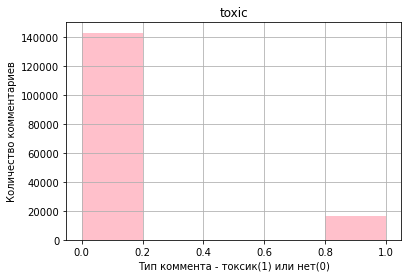

In [11]:
data.hist(color='pink', bins=5);
plt.xlabel('Тип коммента - токсик(1) или нет(0)')
plt.ylabel('Количество комментариев');

In [12]:
print(len(data[data['toxic']==1])/len(data))
len(data[data['toxic']==0])/len(data)

0.10161213369158527


0.8983878663084147

Баланс классов сильно нестабилен. Посмотрим как это скажется на метриках.

Подготовка корпуса:

In [13]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    return ' '.join([WordNetLemmatizer().lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])

def clear_text(text):
    return ' '.join(re.sub(r'[^a-zA-Z]',' ', text).split())
    
def clear_stopwords(text, stopwords): 
    return ' '.join([i for i in nltk.word_tokenize(text) if not i in stopwords])

def clear(text, stopwords):
    return (clear_stopwords(clear_text(lemmatize(text.lower())), stopwords))

In [14]:
#corpus = list(data['text'])
stopwords = set(stopwords.words('english'))

In [15]:
#data['text_parsed'] = data['text'].apply(lambda x: clear(x,stopwords))

In [16]:
#check

#data.sample(5)

In [19]:
#data.to_csv('toxic_comments_parsed.csv')

## Обучение

Выполнили подготовку корпуса. Так как он очень объемный, создали новый csv для экономии времени. Очистка заняла более 2,5 часов.

In [20]:
#подгрузили тот csv, что сделали в ячейке выше

data = pd.read_csv('toxic_comments_parsed.csv', index_col=0)
data.sample(5)

,text,toxic,text_parsed
71852,.\n\n Thanks \n\nYou probably get a million of...,0,thanks probably get million quickimgdelete inv...
67872,It was one of the versions of Transformers Uni...,0,one version transformer universe comic book
93542,"""\nI don't really need to give sources because...",0,n really need give source give dozen time stat...
54473,"""\n\nRepeated falsification of Tabor's views b...",0,repeat falsification tabor view several ip jud...
63518,Not sure about sound quality. Possibly the pdf...,0,sure sound quality possibly pdf assume ite sta...


In [21]:
data.dropna(inplace=True)

In [22]:
train, test = train_test_split(data, train_size=0.6, stratify=data['toxic'], random_state=42)

corpus_train = train['text_parsed'].values
corpus_test = test['text_parsed'].values

tf = TfidfVectorizer(stop_words=stopwords)
tf_idf = tf.fit(corpus_train)
tf_idf_train = tf_idf.transform(corpus_train)
tf_idf_test = tf_idf.transform(corpus_test)

In [24]:
target_train = train.toxic
features_train = tf_idf_train

In [25]:
log = LogisticRegression(n_jobs=-1, random_state=42)
log.fit(features_train, target_train)

LogisticRegression(n_jobs=-1, random_state=12345)

In [26]:
cross_val_score(log, features_train, target_train, cv=3, scoring='f1', n_jobs=-1).mean()

0.6880560529693683

In [27]:
best_score = 0
best_model_lgb = None
for est in [10,100,1000,1500,2000,2500,3000]:
    lgb_model = LGBMClassifier(boosting_type='gbdt', metric='f1', n_estimators=est, random_state=42, n_jobs=-1)
    lgb_model.fit(features_train, target_train)
    score = cross_val_score(lgb_model, features_train, target_train, cv=3, scoring='f1', n_jobs=-1).mean()
    print('est', est, 'f1', score)
    if best_score<score:
        best_score = score
        best_model_lgb = lgb_model
    else:
        break

est 10 f1 0.6003644513744054
est 100 f1 0.7396117448707663
est 1000 f1 0.7631469853929183
est 1500 f1 0.7601798466900181


In [28]:
best_model_lgb

LGBMClassifier(metric='f1', n_estimators=1000, random_state=12345)

## Выводы

In [29]:
target_test = test.toxic
features_test = tf_idf_test

In [30]:
f1_score(target_test, best_model_lgb.predict(features_test))

0.7665800865800866

Общий вывод:
1. Данные загружены, проверены на дубликаты и пропуски
2. Выполнена лемматизация с учетом pos, текст очищен от с использованием рег выражений (оставили a-zA-z), убрали стоп-слова
3. Обучили логистическую регресию и буст lgbm. 
4. Лучшая метрика у lgbm с гиперпараметром est = 1000. Метрика F1 на тесте - 0.767.